In [13]:
%matplotlib inline
import pennylane as qml
import torch
import torch.autograd as autograd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython import display

## QCircuit parameter
n_wires = 4
n_layers = 3

## Optimizer Settings
boundary_loss_scaling = 100

## ODE parameter
rho = 13
sigma = 10
beta = 8/3
# Solver settings
t_start = 0.0001
t_end   = 0.2
n_steps = 100
# Boundary values
x_0 = 2
y_0 = 1
z_0 = 1

def derivatives_fnc(t, x):
    dx_dt = sigma*(x[1] - x[0])
    dy_dt = x[0]*(rho-x[2]) - x[1]
    dz_dt = x[0]*x[1] - beta*x[2]
    # dx_dt = -1
    # dy_dt = -1
    # dz_dt = -1
    return (dx_dt, dy_dt, dz_dt)

t = torch.linspace(t_start,t_end,n_steps)  
analytical_solution = torch.tensor(solve_ivp(derivatives_fnc, [t_start,t_end+0.000001], [x_0,y_0,z_0], t_eval=t).y)

In [14]:

@qml.qnode(qml.device("default.qubit", wires=n_wires), diff_method="best")
def circuit(x, weights):
    # Embedding
    for i in range(n_wires):
        qml.RY(2*i*torch.arccos((x-t_end/2)/(t_end)),wires = i)
    # Variational ansatz
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_wires))
    # Cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

def my_model(t:torch.Tensor, weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:
    vcircuit = torch.vmap(circuit, in_dims=(0,None))
    xyz = torch.vstack([scaling[0] * vcircuit(t, weights[0]) + biases[0],
            scaling[1] * vcircuit(t, weights[1]) + biases[1],
            scaling[2] * vcircuit(t, weights[2]) + biases[2]])
    return xyz

def loss_diff_fnc(t:torch.Tensor, weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:

    [x_pred, y_pred, z_pred] = my_model(t, weights, biases, scaling)

    grad_outputs_1 = torch.ones_like(x_pred)
    dx_dt_pred = autograd.grad(x_pred, t, grad_outputs=grad_outputs_1, create_graph=True)[0]
    grad_outputs_2 = torch.ones_like(y_pred)
    dy_dt_pred = autograd.grad(y_pred, t, grad_outputs=grad_outputs_2, create_graph=True)[0]
    grad_outputs_3 = torch.ones_like(z_pred)
    dz_dt_pred = autograd.grad(z_pred, t, grad_outputs=grad_outputs_3, create_graph=True)[0]

    # ODE loss
    dx_dt, dy_dt, dz_dt = derivatives_fnc(t, (x_pred, y_pred, z_pred))
    res_1 = dx_dt_pred - dx_dt
    res_2 = dy_dt_pred - dy_dt
    res_3 = dz_dt_pred - dz_dt
    loss_pde = torch.mean(res_1**2) + torch.mean(res_2**2) + torch.mean(res_3**2)    
    return loss_pde

def loss_boundary_fnc(t:torch.Tensor, weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:
    [x_0_pred, y_0_pred, z_0_pred] = my_model(torch.zeros_like(t), weights, biases, scaling)
    loss_boundary = torch.mean((x_0_pred - x_0)**2) + torch.mean((y_0_pred - y_0)**2) + torch.mean((z_0_pred - z_0)**2)
    return boundary_loss_scaling * loss_boundary

def loss_fnc(t:torch.Tensor, weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:

    loss_diff     = loss_diff_fnc(t, weights, biases, scaling)
    loss_boundary = loss_boundary_fnc(t, weights, biases, scaling)

    return loss_boundary + loss_diff

def loss_analytical_fnc(weights, biases, scaling):
    t = torch.linspace(t_start,t_end,n_steps, requires_grad=True)
    [x_pred, y_pred, z_pred] = my_model(t, weights, biases, scaling)

    return torch.mean((x_pred - analytical_solution[0])**2) + torch.mean((y_pred - analytical_solution[1])**2) + torch.mean((z_pred - analytical_solution[2])**2)
    

def optimize(n_iter = 100, verbose=0):
    # Solve ODE numerically
    t = torch.linspace(t_start,t_end,n_steps, requires_grad=True)

    def update(verbose):
        if verbose == 1:
            print(f"Step: {i}  Loss: {loss}")
        elif verbose == 2:
            pass
            fig = plt.figure()
            fig.set_figheight(5)
            fig.set_figwidth(20)

            # Add energy plot on column 1
            ax1 = fig.add_subplot(131)
            ax1.grid()
            ax1.plot(range(len(loss_history)), loss_history, "black", ls="solid", lw=4, alpha=0.6)
            ax1.plot(range(len(loss_diff_history)), loss_diff_history, "g", ls="dotted",lw=2)
            ax1.plot(range(len(loss_boundary_history)), loss_boundary_history, "r", ls="dashed",lw=2)
            ax1.plot(range(len(loss_analytical_history)), loss_analytical_history, "b", ls="dashdot",lw=2)
            ax1.legend(["total loss", "diff loss", "boundary loss", "analytical loss"], fontsize=9, loc=1)
            ax1.set_yscale('log')
            ax1.set_xlabel("Optimization step", fontsize=13)
            ax1.set_ylabel("Loss", fontsize=13)
            ax1.set_title("Loss",fontsize=16)

            ax2 = fig.add_subplot(132, projection='3d')
            ax2.plot(analytical_solution[0], analytical_solution[1], analytical_solution[2], "r",lw=1)
            t = torch.linspace(t_start, t_end, n_steps, requires_grad=True)
            [x,y,z] = my_model(t, weights, biases, scaling)
            ax2.plot(x.detach(),y.detach(),z.detach(), "g",lw=1)
            ax2.legend(["analytical", "quantum"], fontsize=13)
            ax2.set_xlabel("x", fontsize=13)
            ax2.set_ylabel("y", fontsize=13)
            ax2.set_zlabel("z", fontsize=13)
            ax2.set_title("Trajectory",fontsize=16)
            
            ax3 = fig.add_subplot(133)
            ax3.grid()
            ax3.plot(t.detach(), analytical_solution[0], "r", ls="solid",linewidth=5, alpha=0.3)
            ax3.plot(t.detach(), x.detach(), "r", ls="dashed",linewidth=2)
            ax3.plot(t.detach(), analytical_solution[1], "b", ls="solid",linewidth=5, alpha=0.3)
            ax3.plot(t.detach(), y.detach(), "b", ls="dashed",linewidth=2)
            ax3.plot(t.detach(), analytical_solution[2], "g", ls="solid",linewidth=5, alpha=0.3)
            ax3.plot(t.detach(), z.detach(), "g", ls="dashed",linewidth=2)
            ax3.legend(["x_exact","x_quantum","y_exact","y_quantum","z_exact","z_quantum"], fontsize=11)
            ax3.set_xlabel("t", fontsize=13)
            ax3.set_ylabel("[x,y,z]", fontsize=13)
            ax3.set_title("Evolution",fontsize=16)

            display.clear_output(wait=True)
            plt.show()
            print(f"Step: {i}  Loss: {loss}")
    
    for i in range(1,n_iter+1):
        opt.zero_grad()
        loss = loss_fnc(t,weights, biases, scaling)
        #loss = loss_analytical_fnc(weights, biases, scaling)
        loss.backward()
        opt.step()

        loss_history.append(loss.detach())
        loss_diff_history.append(loss_diff_fnc(t, weights, biases, scaling).detach())
        loss_boundary_history.append(loss_boundary_fnc(t, weights, biases, scaling).detach())
        loss_analytical_history.append(loss_analytical_fnc(weights, biases, scaling).detach())

        if i%10 == 0 : update(verbose)

weights = [torch.rand((n_layers, n_wires), requires_grad=True), 
           torch.rand((n_layers, n_wires), requires_grad=True),
           torch.rand((n_layers, n_wires), requires_grad=True)]
biases = [torch.rand(1, requires_grad=True), 
          torch.rand(1, requires_grad=True),
          torch.rand(1, requires_grad=True)]
scaling = [torch.rand(1, requires_grad=True), 
          torch.rand(1, requires_grad=True),
          torch.rand(1, requires_grad=True)]
parameters = weights + biases + scaling

# Create optimizer
opt = torch.optim.Adam(parameters, lr=0.01)
loss_history = []
loss_diff_history = []
loss_boundary_history = []
loss_analytical_history = []

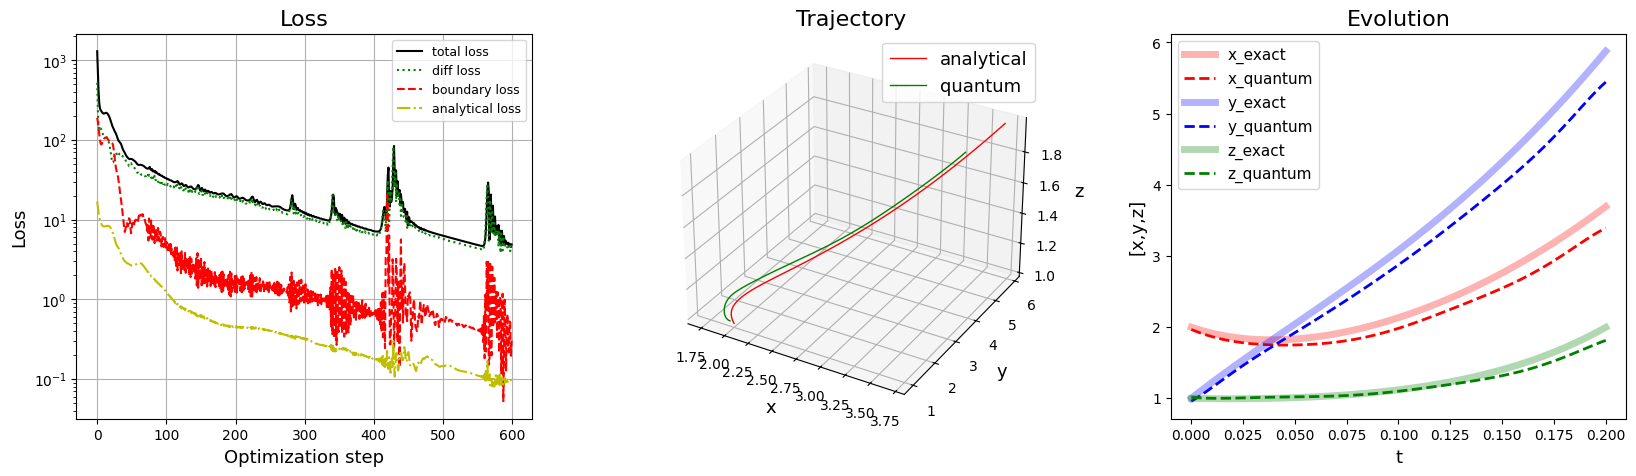

Step: 300  Loss: 4.895356332002754
2min 28s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
# %timeit -n1 -r1 
opt.param_groups[0]["lr"] = 0.1
%timeit -n1 -r1  optimize(n_iter=300, verbose=2)



---
# Following Code is only a sanity check for the derivatives

In [265]:
t = torch.linspace(t_start,t_end,n_steps, requires_grad=True)
[x_pred, y_pred, z_pred] = my_model(t, weights, biases, scaling)

grad_outputs_1 = torch.ones_like(x_pred)
dx_dt_pred = autograd.grad(x_pred, t, grad_outputs=grad_outputs_1, create_graph=True)[0]
grad_outputs_2 = torch.ones_like(y_pred)
dy_dt_pred = autograd.grad(y_pred, t, grad_outputs=grad_outputs_2, create_graph=True)[0]
grad_outputs_3 = torch.ones_like(z_pred)
dz_dt_pred = autograd.grad(z_pred, t, grad_outputs=grad_outputs_3, create_graph=True)[0]

# ODE loss
dx_dt, dy_dt, dz_dt = derivatives_fnc(t, (x_pred, y_pred, z_pred))
res_1 = dx_dt_pred - dx_dt
res_2 = dy_dt_pred - dy_dt
res_3 = dz_dt_pred - dz_dt
loss_pde = torch.mean(res_1**2) + torch.mean(res_2**2) + torch.mean(res_3**2)     

In [249]:
torch.mean(res_3**2)

tensor(0.0017, grad_fn=<MeanBackward0>)

In [252]:
delta_t = t[1]-t[0]
fd_x_pred = torch.diff(x_pred)/delta_t 
fd_x = torch.diff(analytical_solution[0])/delta_t 


In [257]:
t = torch.linspace(t_start,t_end,n_steps, requires_grad=True)
[x_pred, y_pred, z_pred] = my_model(t, weights, biases, scaling)
torch.autograd.grad(scaling[0] * circuit(t[1], weights[0]), t)

(tensor([ 0.0000, -1.0249]),)

In [ ]:
t = torch.linspace(t_start,t_end,n_steps)
sol_analytical = solve_ivp(derivatives_fnc, [t_start,10], [x_0, y_0, z_0], t_eval=t.detach())

ax = plt.figure().add_subplot(projection='3d')

ax.plot(sol_analytical.y[0], sol_analytical.y[1], sol_analytical.y[2], lw=5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")